In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt


### Download data

In [2]:
%%bash

wget -nc -O news-final.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/News_Final.csv 

wget -nc -O facebook-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/Facebook_Microsoft.csv
wget -nc -O googleplus-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/GooglePlus_Microsoft.csv
wget -nc -O linkedin-microsoft.csv http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/LinkedIn_Microsoft.csv


--2020-04-27 12:58:59--  http://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/News_Final.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30338277 (29M) [application/x-httpd-php]
Saving to: ‘news-final.csv’

     0K .......... .......... .......... .......... ..........  0%  248K 1m59s
    50K .......... .......... .......... .......... ..........  0%  492K 89s
   100K .......... .......... .......... .......... ..........  0% 4.36M 62s
   150K .......... .......... .......... .......... ..........  0% 29.0M 46s
   200K .......... .......... .......... .......... ..........  0%  498K 49s
   250K .......... .......... .......... .......... ..........  1% 4.35M 42s
   300K .......... .......... .......... .......... ..........  1%  562K 43s
   350K .......... .......... .......... .......... ..........  1% 

### Load data and set index

In [4]:
news = pd.read_csv('news-final.csv')
news = news[news['Topic']=='microsoft']
news = news.drop('Topic', 1)

news['IDLink'] = news['IDLink'].astype(int)
news = news.set_index('IDLink')


facebook = pd.read_csv('facebook-microsoft.csv')
facebook = facebook.set_index('IDLink')

google = pd.read_csv('googleplus-microsoft.csv')
google = google.set_index('IDLink')

linkedin = pd.read_csv('linkedin-microsoft.csv')
linkedin = linkedin.set_index('IDLink')


### Restrict to articles appearing on all 3 sites

In [5]:
posted_everywhere = news[['Facebook', 'GooglePlus', 'LinkedIn']].min(axis=1) > -1

news = news[posted_everywhere]

### Restrict to sources with at least 50 articles

In [6]:
greater_than_50 = (news['Source'].value_counts() > 50)

sources_50 = greater_than_50[greater_than_50 > 0].index

print("Number of sources with at least 50 articles: {}".format(greater_than_50.sum()))

news = news[news['Source'].isin(sources_50)]


Number of sources with at least 50 articles: 75


### Process dates

In [7]:
news.loc[:, 'PublishDate'] = pd.to_datetime(news['PublishDate'])

news.loc[:, 'Year'] = news['PublishDate'].dt.year
news.loc[:, 'Month'] = news['PublishDate'].dt.month
news.loc[:, 'DayOfWeek'] = news['PublishDate'].dt.weekday
news.loc[:, 'Hour'] = news['PublishDate'].dt.hour

In [8]:
import datetime

In [9]:
datetime.datetime?

In [10]:
news['PublishDate'].max()

may_1_2016 = datetime.datetime(2016, 5, 1)

news_historical = news[news['PublishDate'] <= may_1_2016]
news_new = news[news['PublishDate'] > may_1_2016]

In [11]:
news_new = news_new.drop(['Facebook', 'GooglePlus', 'LinkedIn'], 1)

In [12]:
news_new.to_csv('news-new.csv')

### Summary viz

In [13]:
news.head(2)

,Title,Headline,Source,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Year,Month,DayOfWeek,Hour
IDLink,,,,,,,,,,,,,
311,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0,2015,11,6,5
299,Microsoft’s OneDrive debacle shows its cloud c...,When Microsoft announced earlier this week tha...,Digital Trends via Yahoo! News,2015-11-08 12:15:00,-0.166139,-0.259052,6,0,1,2015,11,6,12


**Year published**

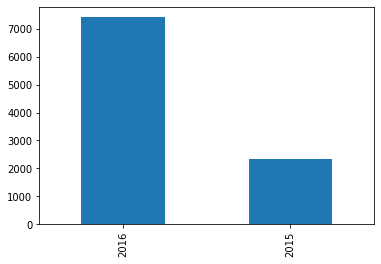

In [14]:
news['PublishDate'].dt.year.value_counts().plot.bar()

**Day of week**

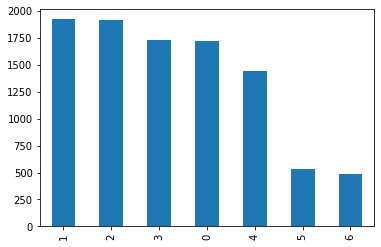

In [15]:
news['PublishDate'].dt.weekday.value_counts().plot.bar()

**Sentiment**

In [16]:
news['ones'] = 1

news.plot.scatter('SentimentTitle', 'ones', alpha=0.1, figsize=(14, 0.5))

plt.axvline(news['SentimentTitle'].mean(), alpha = 0.4, ls='--')

## ML

In [17]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import base

In [18]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return X[self.col_names].values  #REMOVE

In [19]:
df = news_historical.drop(['PublishDate', 'Title', 'Headline'], 1)

In [20]:
source_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['Source'])),
    ('oh', OneHotEncoder())
]) 

source_pipe.fit_transform(df)

hour_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['Hour'])),
    ('oh', OneHotEncoder())
]) 

sentiment_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['SentimentTitle', 'SentimentHeadline']))
])

features = FeatureUnion([
    ('source', source_pipe),
    ('hour', hour_pipe),
    ('sentiment', sentiment_pipe)
])


features.fit_transform(df)

<7941x101 sparse matrix of type '<class 'numpy.float64'>'
	with 30127 stored elements in Compressed Sparse Row format>

In [31]:
facebook_model = Pipeline([
    ('features', features),
    ('model', LinearRegression())
])

facebook_model.fit(df, df['Facebook'])

google_model = Pipeline([
    ('features', features),
    ('model', LinearRegression())
])

google_model.fit(df, df['GooglePlus'])

linkedin_model = Pipeline([
    ('features', features),
    ('model', LinearRegression())
])

linkedin_model.fit(df, df['LinkedIn'])

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('source',
                                                 Pipeline(memory=None,
                                                          steps=[('cst',
                                                                  ColumnSelectTransformer(col_names=['Source'])),
                                                                 ('oh',
                                                                  OneHotEncoder(categories='auto',
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                                                                handle_unknown='error',
                                                                                sparse=True))],
                

## Use models

In [32]:
df_new = news_new

In [33]:
facebook_predict = facebook_model.predict(df_new)

google_predict = google_model.predict(df_new)

linkedin_predict = linkedin_model.predict(df_new)

In [34]:
df_new['FacebookPrediction'] = facebook_predict

df_new['GooglePrediction'] = google_predict

df_new['LinkedInPrediction'] = linkedin_predict

### Compare predicted resutls

In [40]:
df_new[['Title', 'Source', 'FacebookPrediction', 'GooglePrediction', 'LinkedInPrediction']]\
.head()

,Title,Source,FacebookPrediction,GooglePrediction,LinkedInPrediction
IDLink,,,,,
46462,Get a $50 Microsoft Store gift card with Xbox ...,Windows Central,11.570160,2.577800,-7.440152
46791,Flow is Microsoft’s answer to IFTTT,Digital Trends via Yahoo! News,13.221109,0.030471,6.861964
46538,Microsoft's IE loses top browser spot to Googl...,Computer World Australia,44.621996,0.909720,9.187982
46542,This Microsoft legend says the the company is ...,Business Insider via Yahoo! Finance,23.466905,0.650514,16.039449
46569,Windows 10 Mobile Build 10586.306 now being te...,MSPoweruser.com,-2.763371,-1.326493,10.164756
